LDA Topic Modeling
---

Preforming LDA topic modeling with R&R terms.

### Imports

In [1]:
# processing
import operator
from operator import methodcaller
import csv
import re
import numpy as np
import pandas as pd
from pprint import pprint
import string
import math
import itertools
import sqlite3
import copy

# gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models import HdpModel
from gensim.models import TfidfModel

# nltk
from nltk.corpus import stopwords 
from nltk.stem.wordnet import WordNetLemmatizer

# plotting tools
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 


C:\Users\pjz1\AppData\Local\Continuum\anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


### Preprocessing

Read in the output from the R&R program. Tokenize the terms and remove blacklisted tokens. Build a corpora.

In [29]:
# path to blacklisted tokens
blacklist = [t.strip() for t in next(csv.reader(open("tools\\blacklist.csv", 'r')))]

# levels of R&R terms considered
levels = [0, 1, 2, 3]

# format [term, orig, sentence, docID]
inPath = "v1.csv"
inFile = open(inPath, 'r')
inReader = csv.reader(inFile)

In [30]:
docTokens = dict()

# ignore headers
next(inReader)

for inRow in inReader:
    term = inRow[0]
    sentence = inRow[2]
    docID = inRow[3]
    
    # find acceptable tokens only
    token = "_".join([t for t in term.split(":") if re.match(r'[^\W\d]*$', t) and not t in blacklist])

    # calculate new term level
    level = token.count("_")

    # if acceptable, add to dictionary
    if level in levels and not token in blacklist and len(token) > 0:
        if docID in docTokens:
            docTokens[docID] += [token]
        else:
            docTokens[docID] = [token]

# compile all IDs and texts
docIDs = list(docTokens.keys())
texts = list(docTokens.values())

In [31]:
# build a dictionary for the text
dictionary = corpora.Dictionary(texts)
print("Raw dictionary: " + str(len(dictionary)) + " terms")

# filter out terms that appear in fewer that LOW docs or greater than HIGH percent of docs and use KEEP terms
LOW = 1
HIGH = 1
KEEP = 17000

old_dict = copy.copy(dictionary)

dictionary.filter_extremes(no_below = LOW, no_above = HIGH, keep_n = KEEP)
print("Filtered dictionary: " + str(len(dictionary)) + " terms")


# convert the text to a corpus with the dictionary
corpus = [dictionary.doc2bow(text) for text in texts]

Raw dictionary: 19762 terms
Filtered dictionary: 17000 terms


### Modeling

Standard LDA modeling. Toggle the number of topics, passes, and iterations.

In [32]:
def model(corpus, numtop, passes, iterations):

    # run LDA with four cores
    model = gensim.models.LdaMulticore(corpus, 
                                       num_topics=numtop, 
                                       id2word=dictionary,
                                       passes=passes, 
                                       workers=4,
                                       iterations=500)

    return model    

def coherence(corpus, passes):
    
    modle = model(corpus, 4, passes, 500)
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    return coherencemodel.get_coherence()

Perform a set of trials and write results to files.

In [ ]:
# folder to write databases to
STEM = "databases\\"

# set range of passes and topics to test
passes = []
topics = []

for p in passes:
    for t in topics:
        
        # create database
        con = sqlite3.connect(STEM + "topics_p" + str(p+"_t"+str(t)+".db"))
        cur = con.cursor()
        
        # train model
        print("Training LDA...")
        model = model(corpus, p, t, 500)           
        print("Done.")
                              
        # write the topic-terms table
        print("Writing topics to terms...")

        cur.execute("""
            CREATE TABLE IF NOT EXISTS TERMS
                (topic INT,
                term TEXT,
                prob FLOAT)
        """)

        for i in range(lda_model.num_topics):
            topics = lda_model.show_topic(i, topn = 20)
            for t in topics:
                cur.execute("INSERT INTO TERMS (topic, term, prob) VALUES (?, ?, ?)", [i+1, t[0], t[1]])

        print("Done.")
                              
        # write the doc-topics table
        print("Writing doc to topics...")

        cur.execute("""
            CREATE TABLE IF NOT EXISTS DOCS
                (doc TEXT,
                topic INT,
                prob FLOAT)
        """)

        for ID in docIDs:

            doc = docTokens[ID]
            store = list(model.get_document_topics(dictionary.doc2bow(doc)))

            for pair in store:

                cur.execute("INSERT INTO DOCS (doc, topic, prob) VALUES (?, ?, ?)", [docID, pair[0], pair[1]])

        print("Done.")


In [21]:
normalmodel = model(corpus, 7, 10, 500)

coherencemodel = CoherenceModel(model=normalmodel, texts=texts, dictionary=dictionary, coherence='c_v')
print(coherencemodel.get_coherence())




0.41193831076213583


In [22]:
print(normalmodel.print_topics())

[(0, '0.010*"hydrogen_bond" + 0.006*"asymmetric_unit" + 0.006*"crystal_structure" + 0.006*"dihedral_angle" + 0.005*"n_h" + 0.005*"o_hydrogen_bond" + 0.004*"c_h" + 0.003*"benzene_ring" + 0.003*"o_h" + 0.003*"space_group"'), (1, '0.004*"x_ray" + 0.003*"crystal_structure" + 0.002*"space_group" + 0.002*"unit_cell" + 0.002*"n_atom" + 0.002*"dihedral_angle" + 0.002*"aring_resolution" + 0.002*"square_planar" + 0.001*"unit_cell_parameter" + 0.001*"electron_density"'), (2, '0.024*"hydrogen_bond" + 0.009*"o_h" + 0.009*"n_h" + 0.008*"o_hydrogen_bond" + 0.008*"crystal_structure" + 0.007*"c_h" + 0.005*"dihedral_angle" + 0.004*"water_molecule" + 0.004*"crystal_pack" + 0.004*"n_o"'), (3, '0.012*"crystal_structure" + 0.006*"hydrogen_bond" + 0.005*"o_atom" + 0.005*"n_h" + 0.004*"dihedral_angle" + 0.004*"o_h" + 0.004*"x_ray" + 0.003*"c_h" + 0.003*"n_atom" + 0.002*"space_group"'), (4, '0.005*"x_ray" + 0.003*"c_h" + 0.003*"space_group" + 0.003*"crystal_structure" + 0.002*"x_ray_diffraction" + 0.002*"pi_in

Perform cyclical tests, with a lower bound.

In [18]:
def cyclic(minp, rat, p, its):
    
    done = False
    newcorpus = copy.copy(corpus)
    newIDs = docIDs.copy()
    totalTopics = 0
    
    while not done:
        
        t = math.ceil(len(newcorpus) * rat)
        totalTopics += t
        
        newmodel = model(newcorpus, t, p, its)
        
        print(newmodel.print_topics())
        
        badIDs = list()
        
        for ID in newIDs:
            doc = docTokens[ID]
            store = list(newmodel.get_document_topics(dictionary.doc2bow(doc), minimum_probability = minp))
            
            if len(store) == 0:
                badIDs.append(ID)
        
        if len(badIDs) == 0:
            done = True
            
        else:
            newIDs = badIDs
            newcorpus = [dictionary.doc2bow(docTokens[ID]) for ID in newIDs]
            print(len(badIDs))
            
    print("Total topics: " + str(totalTopics))

In [19]:
cyclic(0.85, 0.01, 50, 500)

[(0, '0.018*"n_h" + 0.018*"n_hydrogen_bond" + 0.014*"intermolecular_n_h" + 0.014*"asymmetric_unit" + 0.012*"n_hydrogen" + 0.009*"benzene_ring" + 0.009*"o_h" + 0.008*"o_hydrogen_bond" + 0.006*"x_ray" + 0.006*"pi_interaction"'), (1, '0.011*"weak_c_h" + 0.005*"asymmetric_unit" + 0.005*"o_atom" + 0.005*"o_hydrogen_bond" + 0.004*"o_h" + 0.004*"o_interaction" + 0.004*"x_ray" + 0.003*"weak_c" + 0.003*"water_molecule" + 0.003*"n_atom"'), (2, '0.004*"o_atom" + 0.003*"water_molecule" + 0.003*"x_ray" + 0.002*"octahedral_coordination" + 0.002*"asymmetric_unit" + 0.002*"single_crystal" + 0.002*"active_site" + 0.002*"space_group" + 0.002*"anion_cation" + 0.002*"n_atom"'), (3, '0.019*"o_h" + 0.013*"o_atom" + 0.012*"o_hydrogen_bond" + 0.011*"n_h" + 0.009*"n_atom" + 0.007*"asymmetric_unit" + 0.007*"dimensional_network" + 0.007*"water_molecule" + 0.006*"intermolecular_o_h" + 0.006*"c_o"'), (4, '0.003*"intermolecular_c_h" + 0.003*"x_ray" + 0.002*"o_atom" + 0.002*"o_hydrogen_bond" + 0.002*"c_n_h" + 0.002*

### Output Topics

### Coherence Testing

Test a range for the ideal number of topics.

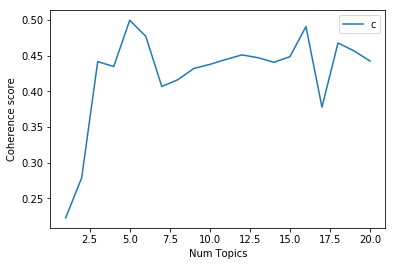

In [20]:
topics = range(1, 21)
passes = 5
iterations = 500

model_list = list()
coherence_values = list()

for topicnum in topics:

    model = gensim.models.LdaMulticore(corpus, num_topics=topicnum, id2word=dictionary, passes=passes, workers =4, iterations=iterations)
    model_list.append(model)
    
    coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())


plt.plot(topics, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

### Visualization

In [22]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(normalmodel, corpus, dictionary)

C:\Users\pjz1\AppData\Local\Continuum\anaconda3\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
8      0.034827 -0.108386       1        1  16.250656
3      0.008008  0.034353       2        1  11.706390
1     -0.131122 -0.049512       3        1  11.282868
2      0.050126  0.037157       4        1  10.272909
0      0.061398  0.004604       5        1   9.825865
7      0.040508 -0.078703       6        1   9.108976
5     -0.094514  0.032363       7        1   8.243443
6     -0.028789  0.035077       8        1   7.959375
4      0.016075  0.070302       9        1   7.915718
9      0.043485  0.022743      10        1   7.433795, topic_info=     Category        Freq                Term       Total  loglift  logprob
302   Default   99.000000                 c_h   99.000000  30.0000  30.0000
137   Default  145.000000                 ray  145.000000  29.0000  29.0000
253   Default   86.000000                  pi   86.000000  28.0000  28.0000
565   Default   66.000000                   c   66.000000  27.0000  27.0000
5089  Default   29.000000  intermolecular_n_h   29.000000  26.0000  26.0000
662   Default   28.000000              region   28.000000  25.0000  25.0000
5312  Default   37.000000            weak_c_h   37.000000  24.0000  24.0000
305   Default   67.000000      dihedral_angle   67.000000  23.0000  23.0000
5076  Default   66.000000                 n_h   66.000000  22.0000  22.0000
5163  Default   39.000000        benzene_ring   39.000000  21.0000  21.0000
434   Default   78.000000               chain   78.000000  20.0000  20.0000
432   Default   43.000000              cation   43.000000  19.0000  19.0000
258   Default   17.000000               prime   17.000000  18.0000  18.0000
299   Default   49.000000             benzene   49.000000  17.0000  17.0000
1114  Default   34.000000                gene   34.000000  16.0000  16.0000
156   Default   74.000000               x_ray   74.000000  15.0000  15.0000
1628  Default   13.000000              square   13.000000  14.0000  14.0000
3084  Default   11.000000         institution   11.000000  13.0000  13.0000
374   Default   75.000000             complex   75.000000  12.0000  12.0000
9418  Default    8.000000             address    8.000000  11.0000  11.0000
26    Default   58.000000               minus   58.000000  10.0000  10.0000
1911  Default   50.000000                acid   50.000000   9.0000   9.0000
273   Default   44.000000               anion   44.000000   8.0000   8.0000
79    Default   33.000000            sequence   33.000000   7.0000   7.0000
5063  Default   34.000000     n_hydrogen_bond   34.000000   6.0000   6.0000
1436  Default   21.000000          coordinate   21.000000   5.0000   5.0000
9540  Default    6.000000                 fee    6.000000   4.0000   4.0000
324   Default   30.000000      pi_interaction   30.000000   3.0000   3.0000
1009  Default   54.000000                type   54.000000   2.0000   2.0000
2324  Default   25.000000               chair   25.000000   1.0000   1.0000
...       ...         ...                 ...         ...      ...      ...
5617  Topic10    3.807304                flow   15.120865   1.2200  -6.3026
249   Topic10    6.728662             network   48.039902   0.6335  -5.7332
491   Topic10    6.319048               model   46.054119   0.6129  -5.7960
1466  Topic10    3.722785               field   15.303061   1.1856  -6.3251
374   Topic10    8.025684             complex   75.916458   0.3521  -5.5569
44    Topic10    7.019139               study   58.794876   0.4737  -5.6909
1114  Topic10    5.396303                gene   34.164719   0.7537  -5.9538
373   Topic10    2.942537              column    9.926782   1.3832  -6.5603
451   Topic10    5.833328               order   44.821495   0.5600  -5.8759
292   Topic10    6.734366               plane   63.186848   0.3603  -5.7323
21    Topic10    6.728692            geometry   68.117691   0.2843  -5.7332
434   Topic10    6.949918               c

### Comparisons

In [36]:
stop = set(stopwords.words('english'))
exclude = set(string.punctuation) .union(string.digits)
lemma = WordNetLemmatizer()
def clean(doc):
    stop_free = " ".join([i for i in doc.lower().split() if i not in stop and i not in blacklist])
    punc_free = ''.join(ch for ch in stop_free if ch not in exclude)
    normalized = " ".join(lemma.lemmatize(word) for word in punc_free.split())
    return normalized

# build a dictionary for the text
testDict = corpora.Dictionary(testTexts)

# filter out terms that appear in fewer that LOW docs or greater than HIGH percent of docs and use KEEP terms
LOW = 1
HIGH = 0.15
KEEP = 17000


testDict.filter_extremes(no_below = LOW, no_above = HIGH, keep_n = KEEP)


# convert the text to a corpus with the dictionary
testCorpus = [testDict.doc2bow(text) for text in testTexts]



In [35]:
# path to blacklisted tokens
blacklist = [t.strip() for t in next(csv.reader(open("tools\\blacklist.csv", 'r')))]

# levels of R&R terms considered
levels = [1, 2, 3]

# format [term, orig, sentence, docID]
inPath = "v1.csv"
inFile = open(inPath, 'r')
inReader = csv.reader(inFile)


docTokens = dict()

next(inReader)

for inRow in inReader:
    term = inRow[0]
    sentence = inRow[2]
    docID = inRow[3]
    
    if docID in docTokens:
        if sentence not in docTokens[docID]:
            docTokens[docID] += sentence
    else:
        docTokens[docID] = sentence

rawtext = docTokens.values()

testTexts = [clean(doc).split() for doc in rawtext] 


In [37]:
hdp = HdpModel(testCorpus, testDict, T=6)
model = hdp.suggested_lda_model()

coherencemodel = CoherenceModel(model=model, texts=testTexts, dictionary=testDict, coherence='c_v')
print(coherencemodel.get_coherence())
    

0.8047293718640184


In [33]:

passes = [5, 8, 12, 20, 25, 32, 40, 50, 65, 80, 100]
coh1 = [0.7366002210076883, 0.7535347175289635, 0.7187085520419347, 0.7370655815312012, 0.7506638360329289, 0.723436962920069, 0.7047308664311466, 0.728423912120161, 0.7127082698428088, 0.7028986124848099, 0.7565239306707477]
coh2 = list()

for p in passes:
    print(p)
    result = coherence(corpus, p)
    print(result)
    coh2.append(result)




5


ValueError: This topic model is not currently supported. Supported topic models should implement the `get_topics` method.

In [23]:
plt.plot(passes, coh1, 'r', label = "R&R")
plt.plot(passes, coh2, 'b', label = "Unigram")
plt.xlabel("Passes")
plt.ylabel("Coherence score")
plt.legend()
plt.show()

NameError: name 'passes' is not defined